# Иерархическая кластеризация точек на прямой
Так как мы рассматриваем частный случай, когда все точки лежат на одной прямой, кластеризацию можно осуществить следующим образом:
- Сортируем все точки, чтобы получить их в правильном порядке.
- Считаем расстояния между всеми соседними точками.
- Сортируем расстояния, чтобы получить порядок объединения кластеров.
- Объединяем кластеры в полученном порядке до тех пор, пока расстояние между точками не превышает заданного порога. При этом будем присоединять кластер меньшего размера к классу большего, чтобы сократить издержки на обновление номера кластера для точек.

Плохо такая кластеризация будет работать в случае, если все точки будут на одинаковом расстоянии друг от друга: в таком случае кластеры будут получаться абсолютно нерепрезентативными.

In [1]:
import numpy as np

class LineHierarhicalClustering:
    def __init__(self, points):
        self.points = np.array(points)
        assert(len(points.shape) == 2)
        self.__prepare_points()
        
    def show_dists(self):
        print('distances:', self.dists)
        
    def cluster(self, n_clusters=-1, threshold=-1):
        assert(n_clusters != -1 or threshold != -1)
        if (n_clusters != -1):
            assert(0 < n_clusters <= len(self.points))
        else:
            assert(0 <= threshold)
        
        # "result" shows cluster id of each point and "groups" maps cluster id to list of this cluster's points
        result = np.array([i for i in range(len(self.points))])
        groups = dict(zip(result, [[i] for i in result]))
        
        # merging groups untill we face the threshold
        cur_n_clusters = len(self.points)
        for dist, pair in zip(self.dists, self.pairs):
            if (n_clusters != -1):
                if (n_clusters == cur_n_clusters):
                    break
            else:
                if (dist > threshold):
                    break
                
            group_id0, group_id1 = result[pair[0]], result[pair[1]]
            group0, group1 = groups[group_id0], groups[group_id1]
            if len(group0) > len(group1):
                result[group1] = group_id0
                group0 += group1
                group1 = []
                # del groups[group_id1]
            else:
                result[group0] = group_id1
                group1 += group0
                group0 = []
                # del groups[group_id0]
            cur_n_clusters -= 1
            
        # refine clusters ids to be in range(0, n_clusters)
        refined_cluster_id = 0
        prev_clst_id = result[0]
        for i in range(1, len(result)):
            if result[i] != prev_clst_id:
                refined_cluster_id += 1
            prev_clst_id = result[i]
            result[i] = refined_cluster_id
        result[0] = 0
            
        print('nubmer of clusters:', len(groups))
        return result[self.sorted_points_order.argsort()]        
    
    def __prepare_points(self):
        # sort points to place it on the line in right order
        self.sorted_points_order = np.lexsort((points[:,0],points[:,1]))
        self.points = self.points[self.sorted_points_order]
            
        # get valid pairs of points and distances between them
        n_pairs = len(self.points) - 1
        self.dists = np.zeros(n_pairs)
        self.pairs = np.zeros((n_pairs, 2), dtype=int)
        for i in range(n_pairs):
            p1 = self.points[i]
            p2 = self.points[i+1]
            self.dists[i] = np.sqrt(np.square(p1[0] - p2[0]) + np.square(p1[1] - p2[1]))
            self.pairs[i] = [i, i+1]
            
        # sort in unisson distances and corresponding pairs of points
        sorted_dists_inds = self.dists.argsort()
        self.dists = self.dists[sorted_dists_inds]
        self.pairs = self.pairs[sorted_dists_inds]

# Пример работы

In [2]:
points = np.array([[1,1], [6.5,6.5], [4,4], [5,5], [7,7], [8,8], [2,2]])
LHC = LineHierarhicalClustering(points)
LHC.show_dists()

distances: [0.70710678 1.41421356 1.41421356 1.41421356 2.12132034 2.82842712]


In [3]:
cluster_ids = LHC.cluster(threshold = 2)
# cluster_ids = LHC.cluster(n_clusters = 3)
print(cluster_ids)

nubmer of clusters: 7
[0 2 1 1 2 2 0]


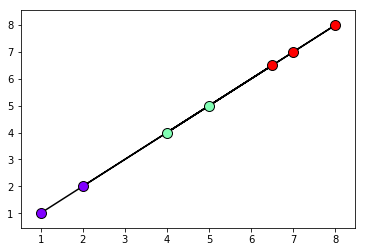

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 

n_clusters = len(np.unique(cluster_ids))
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
plt.plot(points[:,0], points[:,1], color='k', zorder=1)
for cluster_id, color in enumerate(colors):
    clst_pts = points[np.where(cluster_ids == cluster_id)[0]]
    plt.scatter(clst_pts[:,0], clst_pts[:,1], color=color, s=100, zorder=2, edgecolor='k')
plt.show()